In [ ]:
#comment

In [2]:
!pip3 install scikit-learn==0.24.1 aif360==0.3.0  nodejs==0.1.1 ipywidgets==7.6.3 lime==0.2.0.1 wget==3.2 #aix360==0.2.1 


  Using cached scikit_learn-0.24.1-cp39-cp39-macosx_10_13_x86_64.whl (7.3 MB)
  Using cached aif360-0.3.0-py3-none-any.whl (165 kB)
     |████████████████████████████████| 121 kB 633 kB/s eta 0:00:01
     |████████████████████████████████| 275 kB 13.1 MB/s eta 0:00:01
  Created wheel for nodejs: filename=nodejs-0.1.1-py3-none-any.whl size=3492 sha256=1d93695fc43e2d1703b1b7290de9fab0790bc721fe5aeb4dc3e2dbd5a764d9af
  Stored in directory: /Users/janickbrunner/Library/Caches/pip/wheels/33/6c/3e/c7c4e543b09f8fc396bb9d2bb0ee2c73d248c49201593c901e
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=813cd4e5a8ddb06644a8a5823d1727607072b6170c1f4341e39de912fdba532c
  Stored in directory: /Users/janickbrunner/Library/Caches/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=a949589a7f38123e72ad876077a30cdde74342bd13295dafac359d55b56a487b
  Stored in directory: /Users/

In [1]:
import wget
wget.download(
    'https://raw.githubusercontent.com/'
    'elyra-ai/component-library/master/claimed_utils.py'
)

'claimed_utils (1).py'

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from claimed_utils import unzip
import os.path
import glob
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

In [5]:
# @dependency codait_utils.ipynb
# @dependency model.zip
# @dependency data.zip
# @param model zip file name
# @param data zip file name
# @returns random heatmap image
# objects inline in jupyter (currently 4,TODO make specifiable)
# (next version will return a zip folder with images+heatmaps)

In [11]:
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager


In [7]:
model = keras.models.load_model('my_model.h5')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


2022-10-02 21:22:35.809245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
folder = glob.glob("02_train_test_split/*")
num_classes = len(folder)

batch_size = 32
img_height = 244
img_width = 244
input_shape = (img_width, img_height)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '02_train_test_split',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '02_train_test_split',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

Found 2421 files belonging to 2 classes.
Using 1937 files for training.
Found 2421 files belonging to 2 classes.
Using 484 files for validation.


In [34]:
explainer = lime_image.LimeImageExplainer()


In [35]:
val_ds_shuffeled = val_ds.shuffle(1)
for image, label in val_ds:
    break
label = label[0]
label = tf.reshape(label, [1, len(label)])
tf.math.argmax(label, 1)
label = tf.math.argmax(label, 1).numpy()[0]  # de-onehotencode

In [36]:
def get_random_image():
    for image, label in val_ds:
        break
    image = image.numpy().astype(int)
    image = image[0]
    label = label[0]
    label = tf.reshape(label, [1, len(label)])
    image = image.reshape(img_height, img_width, 3)
    image_for_model = image.reshape(1, img_height, img_width, 3)
    label = tf.math.argmax(label, 1).numpy()[0]  # de-onehotencode
    prediction = model.predict(image_for_model)
    prediction = tf.math.argmax(prediction, 1).numpy()[0]  # de-onehotencode
    return image, label, prediction

In [37]:
def get_explaination_as_mask(image, label):
    segmentation_fn = SegmentationAlgorithm(algo_type='slic')
    explanation = explainer.explain_instance(
        image,
        model.predict,
        segmentation_fn=segmentation_fn
    )
    print(label)
    return explanation.get_image_and_mask(label)[1]

In [38]:
def merge_image_with_mask(image, mask):
    np_mask = np.array(mask.astype(int) * 255, np.uint8)
    np_merged = np.empty(image.shape, np.uint8)
    np_merged[:, :, 0] = np.maximum(image[:, :, 0], np_mask)
    np_merged[:, :, 1] = np.maximum(image[:, :, 1], np_mask)
    np_merged[:, :, 2] = np.maximum(image[:, :, 2], np_mask)
    return np_merged

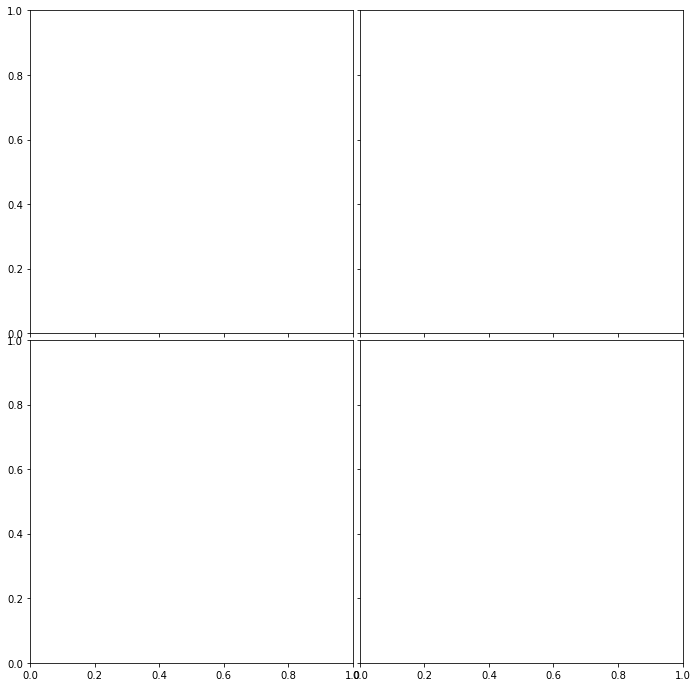

In [39]:
fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),
                 axes_pad=0.1,  # pad between axes in inch.
                 )

In [40]:
for ax in grid:
    try:
        image, label, prediction = get_random_image()
        mask = get_explaination_as_mask(image, label)
        masked_image = merge_image_with_mask(image, mask)
        ax.imshow(masked_image)
    except KeyError:ç
        print('Model label, Lame label missmatch')

plt.show()

ValueError: in user code:

    File "/Users/janickbrunner/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/Users/janickbrunner/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/janickbrunner/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/janickbrunner/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/Users/janickbrunner/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/janickbrunner/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 244, 244, 3)
